In [220]:
# import warnings
# warnings.filterwarnings("ignore")

In [221]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,f1_score

In [222]:
#reading dataset
data=pd.read_csv('/home/crossml/Downloads/data_b.csv')
df=data.copy(deep=True)
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,NaN,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,NaN,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


In [223]:
#replacing 0 with NaN
cols = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
df[cols] = df[cols].replace({'0':np.nan, 0:np.nan})

In [224]:
#replacing missing values
df1=df.copy(deep=True)
for column in df1[['BloodPressure', 'BMI']]:
 df1[column]=df1[column].fillna(df1[column].mean())
for column in df1[['Pregnancies','Glucose','DiabetesPedigreeFunction','Age']]:
 df1[column]=df1[column].fillna(df1[column].mean())

In [225]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean',)
imputed_data = imputer.fit_transform(df1) 
df2 = pd.DataFrame(imputed_data)
df2.columns = df1.columns

In [226]:
#handling the outliers
def detect_outliers(df2):
    outliers= pd.DataFrame(columns=["Feature","No.of Outliers","Handled?"])
    for col in list(set(df2.select_dtypes(include=np.number).columns)-{'Outcome'}):
        q1 = df2[col].quantile(0.25)
        q3 = df2[col].quantile(0.75)
        iqr = q3 - q1
        low = q1 - (1.5*iqr)
        high = q3 + (1.5*iqr)
        n = df2.loc[(df2[col] < low) | (df2[col] > high)].shape[0]
                   
        df2.loc[(df2[col] < low),col] = low
        df2.loc[(df2[col] > high),col] = high
 #let's fix them
#df[col] = np.where((df[col] > fence_high) | (df[col] > fence_high),df[col].median(),df[col])
        outliers = outliers.append({'Feature': col, "No.of Outliers": n ,"Handled?": df2[col].all() < high},ignore_index=True)
    return outliers
detect_outliers(df2)

,Feature,No.of Outliers,Handled?
0,Pregnancies,4,True
1,DiabetesPedigreeFunction,35,True
2,Age,9,True
3,BloodPressure,13,True
4,SkinThickness,5,True
5,Insulin,33,True
6,BMI,12,True
7,Glucose,2,True


[0.09149931 0.25362329 0.08073384 0.08885502 0.1273803  0.13052423
 0.09363327 0.13375074]


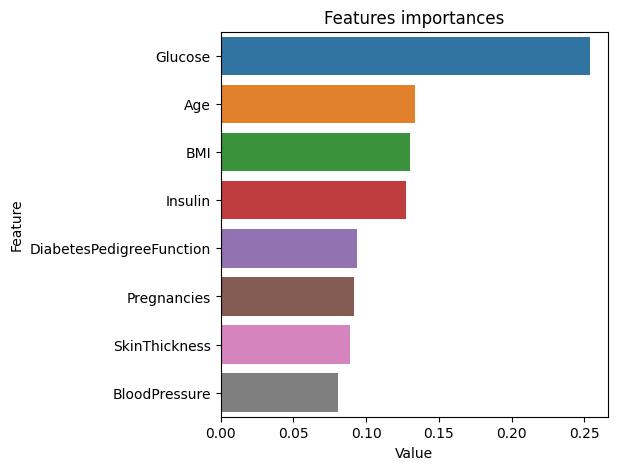

In [227]:
from sklearn.ensemble import ExtraTreesRegressor 
x=df2.drop("Outcome", axis=1)
y = df2.Outcome
model.fit(x,y)
print(model.feature_importances_)
#visualizing by bar graph
feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': x.columns})
plt.figure(figsize=(5, 5))
sns.barplot(x="Value",y="Feature", data=feature_imp.sort_values(by="Value",ascending=False))
plt.title('Features importances')
plt.show()

In [228]:
#scaling is required before applying pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(x)
scaled_data=pd.DataFrame(scaled_data)
scaled_data
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(scaled_data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2','PC3','PC4'])
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.32522962 0.18029869 0.14600216 0.11959445]


In [229]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [230]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [231]:
#evaluating the decision tree and random forest model for different values of parameters
model_params={
    "decision_tree":{
        'model':DecisionTreeClassifier(random_state=0),
        'params':{
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth':[3,4,5,6],
              'criterion':['gini', 'entropy', 'log_loss']
        }
    },
     "random_forest":{
        'model': RandomForestClassifier(),
        'params':{
            'n_estimators': [10,50,100], 
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth':[3,4,5,6],
            'criterion':['gini', 'entropy', 'log_loss']
              
  
        }
    }
}


In [232]:
# try each model with the scaled data
scores_scaled = []
for mn,mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'],cv=5,return_train_score=False)
    clf.fit(x_train,y_train)
    scores_scaled.append({
        'model' : mn,
        'best score': clf.best_score_,
        "best params": clf.best_params_
    })
    
df3 = pd.DataFrame(scores_scaled, columns=["model","best score",'best params'])
df3.sort_values(by=['best score'], ascending=False)


,model,best score,best params
1,random_forest,0.762282,"{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}"
0,decision_tree,0.732920,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2'}"


In [233]:
# Splitting the dataset into the Training set and Test set for scaled data
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(scaled_data, y, test_size=0.2, random_state=0)

In [234]:
#evaluating svm,logistic regression and gradient boosting for scaled data
model_params2={
 "svm":{
 'model': SVC(random_state=0),
 'params':{
 'C': [0.1, 1, 10, 100, 1000], 
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 'kernel': ['rbf','linear']
 }
 },
 'logistic_regression':{
 'model': LogisticRegression(),
 'params':{'penalty':[ 'l2', 'elasticnet', None], 
 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
 'C': [1,5,10]
 }
 },
"gradient_boosting":{
 'model': GradientBoostingClassifier(),
 'params':{
 'max_depth':[3,4,5],
 'n_estimators':[5,10,50,100],
 'criterion':['friedman_mse', 'squared_error', 'mse']
 }
 
 }
}

In [235]:
scores_scaled2 = []
for mn,mp in model_params2.items():
 clf2 = GridSearchCV(mp['model'],mp['params'],cv=5,return_train_score=False)
 clf2.fit(x_train1,y_train1)
 scores_scaled2.append({
 'model' : mn,
 'best score': clf2.best_score_,
 "best params": clf2.best_params_
 })
 
df4 = pd.DataFrame(scores_scaled2, columns=["model","best score",'best params'])


In [236]:
df4.sort_values(by=['best score'], ascending=False)

,model,best score,best params
1,logistic_regression,0.760602,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"
0,svm,0.757337,"{'C': 10, 'gamma': 1, 'kernel': 'linear'}"
2,gradient_boosting,0.742663,"{'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 100}"


In [240]:
#since random forest classifier gave best accuracy, so applying that
model_final = RandomForestClassifier(criterion= 'gini',max_depth= 4,max_features='log2',n_estimators=100)
model_final.fit(x_train, y_train)
y_pred1 = model_final.predict(x_test)
print('Accuracy of model for testing data is ',accuracy_score(y_test,y_pred1))


Accuracy of model for testing data is  0.7857142857142857


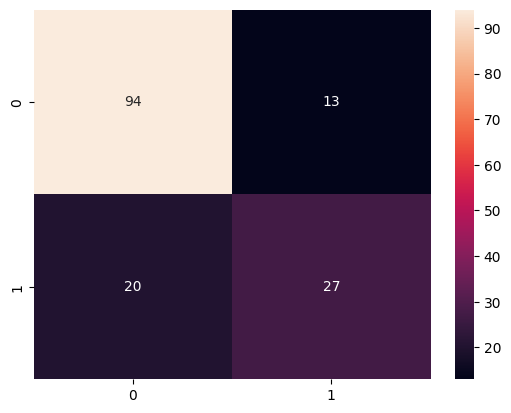

In [241]:
#heatmap for confusion matrix
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred1)),annot=True)
plt.show()

In [244]:
#checking for avg accuracy of the model
from sklearn.model_selection import cross_val_score
score = cross_val_score(model_final, x, y, cv=5)
accuracy_rate = []
accuracy_rate.append(score.mean())
print('Average accuracy of the final model is ',accuracy_rate)


Average accuracy of the final model is  [0.7565826330532213]
